In [223]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import plotly.offline as py
import seaborn as sb
py.init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm,tree
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,precision_recall_curve,confusion_matrix,precision_score,confusion_matrix
import copy
#Performing OverSample using SMOTE(Synthetic Minority Over Sampling Technique)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
smote=SMOTE()

In [210]:
#Data defination
attrition = pd.read_csv('employee_data.csv')


In [209]:
num_timestamps = 3
a = attrition.columns.values
#c = attrition.dtypes
# for col_name in a:
#     if not np.issubdtype(attrition[col_name].dtype,np.number):
#         attrition[[col_name]] = intify(attrition.get(col_name))

#pd.DataFrame(data=attrition, columns = [a[0]]).Age.dtype
#attrition.Department = intify(attrition.Department)
#attrition.Department
#not numpy.issubdtype(attrition['Age'].dtype,numpy.number)
attrition.Attrition = attrition.Attrition - 1
attrition.to_csv('new_converted_data.csv')
attritions = np.array_split(attrition,num_timestamps)
for i in range(num_timestamps-1,-1,-1):
    attritions[i].index = range(0,1470)

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [201]:
attritions[0].columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [228]:
#Replacing Yes with 1 and No with 0 in Attrition Column
hr_data = pd.read_csv('employee_data.csv')
hr_data['Attrition']=np.where(hr_data['Attrition']=='No', #condition
                 0, #value if conditioemployee_data.csvn is true
                 1)
hr_data=hr_data.drop(['EmployeeCount', 'StandardHours','EmployeeNumber'], axis=1)

In [245]:
# corr_matrix = hr_data.corr()
# f , ax = plt.subplots(figsize=(20,12))
# sb.heatmap(corr_matrix,vmax=0.8, annot=True)

numerical_df=hr_data.select_dtypes(include=np.number)
categorical_df=hr_data.select_dtypes(exclude=np.number)
numeric_cols=list(numerical_df.columns)
categorical_cols=list(categorical_df.columns)

# for n in categorical_cols:
#     print(pd.crosstab(hr_data['Attrition'],hr_data[n],normalize='columns'))

categorical_df_dummies=pd.get_dummies(hr_data[categorical_cols],drop_first=True)
final_df=pd.concat([categorical_df_dummies,numerical_df],axis=1)
final_df.head()

y=final_df.Attrition
X=final_df.drop(['Attrition'], axis=1)

#Method that applies model on the data and Predict the attrition
def model(mod,model_name,x_tr,y_tr,x_tes,y_te):
    mod.fit(x_tr,y_tr)
    pred_dt=mod.predict(x_tes)
    print("     ",model_name,"      ")
    print("Accuracy ",accuracy_score(pred_dt,y_te))
    print("ROC_AUC  ",roc_auc_score(pred_dt,y_te))
    cm=confusion_matrix(pred_dt,y_te)
    print("Confusion Matrix  \n",cm)
    print("                    Classification Report \n",classification_report(pred_dt,y_te))

In [246]:
X_sm, y_sm=smote.fit_sample(X,y)
X_train_sm,X_test_sm,y_train_sm,y_test_sm=train_test_split(X_sm,y_sm,test_size=0.2,random_state=100)

rf_sm=RandomForestClassifier(n_estimators=10,max_depth=4)
model(rf_sm,"Random Forest",X_train_sm,y_train_sm,X_test_sm,y_test_sm)

      Random Forest       
Accuracy  0.8724696356275303
ROC_AUC   0.8727690288713911
Confusion Matrix  
 [[219  35]
 [ 28 212]]
                    Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.86      0.87       254
           1       0.86      0.88      0.87       240

   micro avg       0.87      0.87      0.87       494
   macro avg       0.87      0.87      0.87       494
weighted avg       0.87      0.87      0.87       494



In [247]:
clf = rf_sm

In [5]:
df = copy.deepcopy(attritions[0])
del df['Attrition']
del df['EmployeeNumber']
df['SatistactionJobEnviroment'] = attritions[0].JobSatisfaction*attritions[0].EnvironmentSatisfaction
df['SatistactionJobRelation'] = attritions[0].JobSatisfaction*attritions[0].RelationshipSatisfaction
# df['SatistactionRelationEnviroment'] = attritions[0].RelationshipSatisfaction*attritions[0].EnvironmentSatisfaction
df['attrition'] = attritions[0].Attrition

In [174]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df.head()
true_data,false_data = df[df['attrition']==1], df[df['attrition']==0]
a = np.arange(len(false_data))
np.random.shuffle(a)
b = np.arange(len(true_data))
np.random.shuffle(b)
t1 = true_data.iloc[b[0:170]]
t2 = true_data.iloc[b[170:len(true_data)]]
f1 = false_data.iloc[a[0:250]]
f2 = false_data.iloc[a[250:500]]
f3 = false_data.iloc[a[500:750]]
f4 = false_data.iloc[a[750:1000]]
f5 = false_data.iloc[a[1000:len(false_data)]]
test = pd.concat([f5,t2])
train = pd.concat([f1,t1,f2,t1,f3,t1,f4])

In [175]:


# Create two new dataframes, one with the training rows, one with the test rows
# train, test = df[df['is_train']==True], df[df['is_train']==False]

# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 1340
Number of observations in the test data: 300


In [176]:
len(t2)

67

In [177]:
#33
features = df.columns[:(33+2)]

In [178]:
x_train = train
y_train = train['attrition']
train.head()

# Defining test
x_test = test
y_test = test['attrition']

In [185]:
    start = 2
    # Create a random forest Classifier
    clf = RandomForestClassifier(n_estimators=10,max_depth=4)
    C=1.0
#     clf = svm.LinearSVC( C=C,max_iter=10000)
#     clf  = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=3)

    # Train the Classifier to take the training features and learn how they relate to the training y (attrition_num)
    clf.fit(train[features], y_train)
#     clf.set_params(n_estimators=start*2)
#     clf.fit(train[features], y_train)
#     clf.set_params(n_estimators=start*3)
#     clf.fit(train[features], y_train)

    # Apply the Classifier we trained to the test data
    clf.predict(test[features])

    # View the predicted probabilities of the first 10 observations
#     clf.predict_proba(test[features])[0:10]
    preds = clf.predict(test[features])

In [186]:
# Create confusion matrix, WHICH REALLY IS CONFUSING AT FIRST
pd.crosstab(test['attrition'], preds, rownames=['Actual Attrition'], colnames=['Predicted Attrition'])

# View a list of the features and their importance scores
# list(zip(train[features], clf.feature_importances_))

# The accuracy_score function computes the accuracy, either the fraction (default) or the count (normalize=False) of
#correct predictions.
score = accuracy_score(y_test, preds)
score_count = accuracy_score(y_test, preds, normalize=False)
print(score)
print(score_count)

0.8066666666666666
242


In [187]:
f1_score(y_test, preds, average='binary')

0.275

In [182]:
precision_score(y_test,preds)

0.4375

In [183]:
recall_score(y_test,preds)

0.1044776119402985

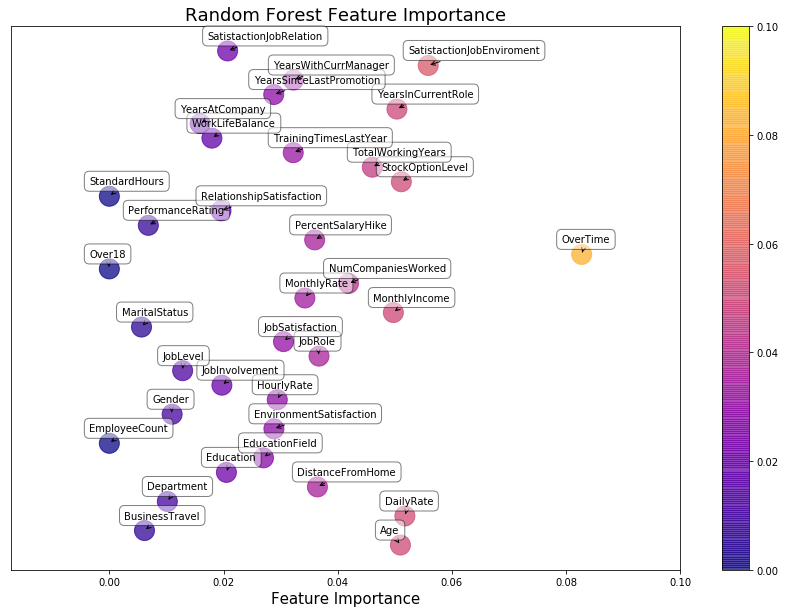

In [184]:
# Scatter plot
y = features
x = clf.feature_importances_
plt.figure(figsize=(15, 10))
plt.scatter(x, y, c=x, vmin=0, vmax=0.10, s=400, alpha = 0.75, cmap='plasma')
plt.colorbar()
#plt.ylabel('Attributes')
plt.xlabel('Feature Importance', fontsize=15)
plt.yticks([])
#plt.xticks(rotation=90)
plt.title('Random Forest Feature Importance', fontsize=18)
labels = features
for label, x, y in zip(labels, x, y):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='left', va='top',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.show() 

In [16]:
for i in range(num_timestamps-1,-1,-1):
    divide = attritions[i].div(attritions[0],axis=1)
    a = (divide.replace([-np.inf,np.inf,np.nan],0)+attritions[i].mul(((divide==np.inf)|(divide==-np.inf) | np.isnan(divide))*1))
    a.EmployeeNumber =  attritions[i].EmployeeNumber
    a.Attrition = attritions[0].Attrition
    attritions[i] = a
    attritions[i].to_csv('normalized_'+ str(i)+'.csv')
